Кирилл Лалаянц, R33352

# Лабораторная работа No9
# В -- 11
## Регуляторов с заданной степенью устойчивости

Импорт необходимых для работы библиотек. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy
import cvxpy 
import array_to_latex as a2l
# plt.rcParams['text.usetex'] = True

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)
np.set_printoptions(precision=2)
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

In [5]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m

def check_controllability(A, B):
    U = get_controllability_matrix(A, B)
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    return np.linalg.matrix_rank(U) == A.shape[0]
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability(C, A):
    V = get_observability_matrix(A, C)
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    return np.linalg.matrix_rank(V) == A.shape[0]

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")


## Task1

In [6]:
task1_A = np.array([
    [-4, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 5],
    [0, 0, -5, 1]
])

task1_B = np.array([[0], 
                    [2], 
                    [0], 
                    [9]])

task1_alphas = np.array([0.1, 1, 2, 3, 4, 5, 10, 20, 50, 100, 1000, 10000])

task1_x0 = np.array([1, 1, 1, 1])

In [7]:
check_controllability_eigens(task1_A, task1_B)

Eigen values of A:
   [1.+5.j]: controllable
   [1.-5.j]: controllable
   [-4.+0.j]: not controllable
   [1.+0.j]: controllable


In [8]:
def task1_simulate(A, B, K, x0, ts):
    print(f'spec(A + B@K): {np.linalg.eigvals(A + B@K)}; stable: {np.all(np.linalg.eigvals(A + B@K).real < 0)}')
    print(a2l.to_ltx(np.linalg.eigvals(A + B@K)))
    ss = control.ss(A + B@K, A*0, A*0, A*0)
    return control.forced_response(ss, X0=x0, T=ts)

def task1_get_K(A, B, alpha):
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y
    
    constraints = [P >> np.eye(4) , lyapunov_lmi << 0]
    objective = cvxpy.Minimize(0)
    
    prob = cvxpy.Problem(objective, constraints)
    try:
        print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
        print(f'spec(P): {np.linalg.eigvals(P.value)}; P >> 0: {np.all(np.linalg.eigvals(P.value).real >= 0)}')
        print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
        # print(P.value)
    except Exception:
        return 0, False
    
    
    return Y.value @ np.linalg.pinv(P.value), True

In [9]:
# fig, axs = plt.subplots(2, 2, figsize=(8, 8))
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
task1_reses = dict()
ts = get_t(10)
for alpha in task1_alphas:
    print(f'========   {alpha = }   =========')
    K, status = task1_get_K(task1_A, task1_B, alpha)
    if not status:
        print(':(')
        continue
    print(f'{K = }')
    task1_reses[alpha] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

========   alpha = 0.1   =========
Optimization error: 0.0
spec(P): [ 4.11 33.2  14.27  2.91]; P >> 0: True
spec(lmi): [-32.05 -14.24 -11.07  -3.05]; lyapunov_lmi <<= 0: True
K = array([[-5.34e-16, -9.12e-01, -2.89e-01, -3.22e-01]])
spec(A + B@K): [-0.68+5.53j -0.68-5.53j -0.36+0.j   -4.  +0.j  ]; stable: True
\begin{bmatrix}
 -0.68 + 5.53j & -0.68 + -5.53j & -0.36 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
None
========   alpha = 1.0   =========
Optimization error: 0.0
spec(P): [12.62 98.08 33.43  2.28]; P >> 0: True
spec(lmi): [-75.74  -4.36 -37.73 -27.74]; lyapunov_lmi <<= 0: True
K = array([[ 3.26e-16, -2.58e+00, -9.45e-01, -3.23e-01]])
spec(A + B@K): [-1.84+6.77j -1.84-6.77j -1.39+0.j   -4.  +0.j  ]; stable: True
\begin{bmatrix}
 -1.84 + 6.77j & -1.84 + -6.77j & -1.39 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
None
========   alpha = 2.0   =========
Optimization error: 0.0
spec(P): [ 53.82 334.89  87.03   2.26]; P >> 0: True
spec(lmi): [-215.29   -8.29 -119.91  -82.84]; lyapunov_lmi <<= 0: 

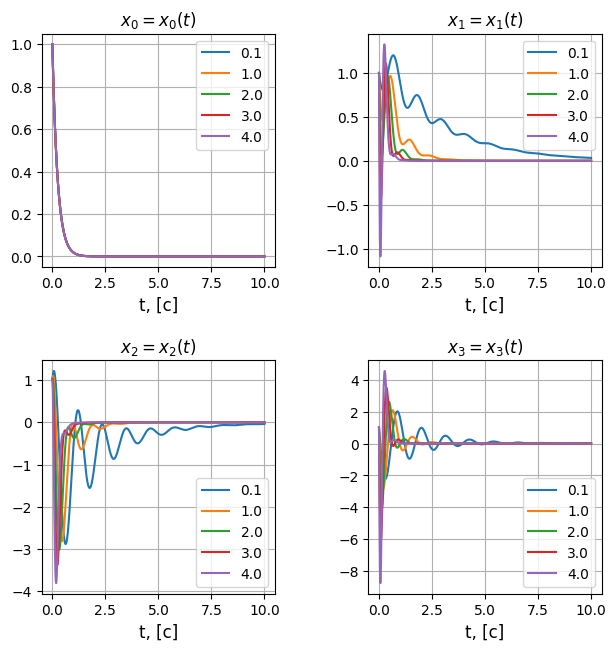

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, alpha in enumerate(task1_reses):
    res, _ = task1_reses[alpha]
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'{alpha}') 
for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task1_states.jpg')

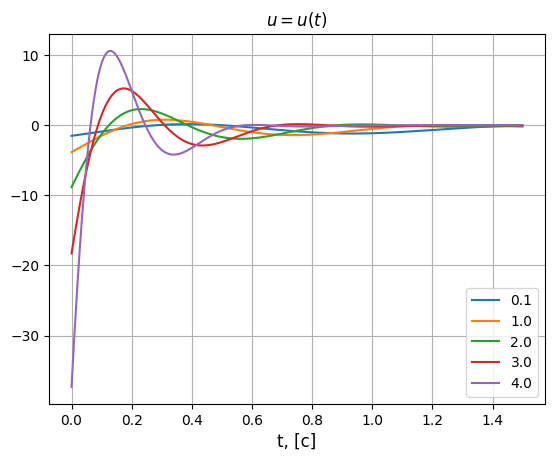

In [11]:
for indx, alpha in enumerate(task1_reses):
    res, K = task1_reses[alpha]
    us = K @ res.states
    plt.plot(ts[:len(ts)//100 * 15], us[0, :len(ts)//100 * 15], label=f'{alpha}') 
plt.xlabel(f"t, [c]", fontsize=12)
plt.title(f"$u = u(t)$", fontsize=12)
plt.grid(True)
plt.legend()
plt.savefig(f'{SAVE_PATH}/task1_us.jpg')

## Task 2

In [12]:
def task2_get_K_with_constraint(A, B, x, alpha, mu):
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y

    new_const1 = cvxpy.bmat([[P, x], [x.T, np.ones((1, 1))]])
    new_const2 = cvxpy.bmat([[P, Y.T], [Y, (mu**2) * np.identity(B.shape[1])]])
    
    constraints = [P >> np.eye(4) , lyapunov_lmi << 0, new_const1 >> 0, new_const2 >> 0]
    objective = cvxpy.Minimize(0)
    prob = cvxpy.Problem(objective, constraints)
    
    try:
        print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
        print(f'spec(P): {np.linalg.eigvals(P.value)}; P >> 0: {np.all(np.linalg.eigvals(P.value).real >= 0)}')
        print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
    except Exception:
        return 0, False
    
    
    return Y.value @ np.linalg.pinv(P.value), True

def task2_get_K_min(A, B, x, alpha):
    mumu = cvxpy.Variable((1, 1))
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y
    new_const1 = cvxpy.bmat([[P, x], [x.T, np.ones((1, 1))]])
    new_const2 = cvxpy.bmat([[P, Y.T], [Y, mumu @ np.identity(B.shape[1])]])
    
    constraints = [P >> np.eye(4), lyapunov_lmi << 0, new_const1 >> 0, new_const2 >> 0]
    objective = cvxpy.Minimize(mumu)
    prob = cvxpy.Problem(objective, constraints)
    try:
        print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
    except Exception:
        return (0, 0, False)
    return np.sqrt(mumu.value)[0][0], Y.value @ np.linalg.pinv(P.value), True


In [13]:
task2_reses1 = dict()
task2_alpha = 1
min_mu, min_K, valid = task2_get_K_min(task1_A, task1_B, task1_x0.reshape(4, 1), task2_alpha)
ts = get_t(5)
for mu in [min_mu, min_mu * 10, min_mu * 100]:
    print(f'========   {mu = }   =========')
    K, status = task2_get_K_with_constraint(task1_A, task1_B, task1_x0.reshape(4, 1), task2_alpha, mu)
    if not status:
        print(':(')
        continue
    task2_reses1[mu] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

Optimization error: 9.500734593363262
========   mu = 3.0823261659602577   =========
Optimization error: 0.0
spec(P): [4.33e+05 4.73e+01 1.55e+00 1.93e+01]; P >> 0: True
spec(lmi): [-2.60e+06 -6.99e-06 -3.41e-06 -2.07e-07]; lyapunov_lmi <<= 0: True
spec(A + B@K): [-1.+5.5j -1.-5.5j -1.+0.j  -4.+0.j ]; stable: True
\begin{bmatrix}
 -1.00 + 5.50j & -1.00 + -5.50j & -1.00 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
None
========   mu = 30.823261659602576   =========
Optimization error: 0.0
spec(P): [ 1.71  8.21 22.88 57.49]; P >> 0: True
spec(lmi): [-48.66  -0.66  -7.06 -14.  ]; lyapunov_lmi <<= 0: True
spec(A + B@K): [-1.35+6.83j -1.35-6.83j -1.17+0.j   -4.  +0.j  ]; stable: True
\begin{bmatrix}
 -1.35 + 6.83j & -1.35 + -6.83j & -1.17 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
None
========   mu = 308.23261659602576   =========
Optimization error: 0.0
spec(P): [ 37.06   5.21  68.64 185.94]; P >> 0: True
spec(lmi): [-222.35   -4.84  -43.65  -73.52]; lyapunov_lmi <<= 0: True
spec(A + B@K): [-1.56+6.6

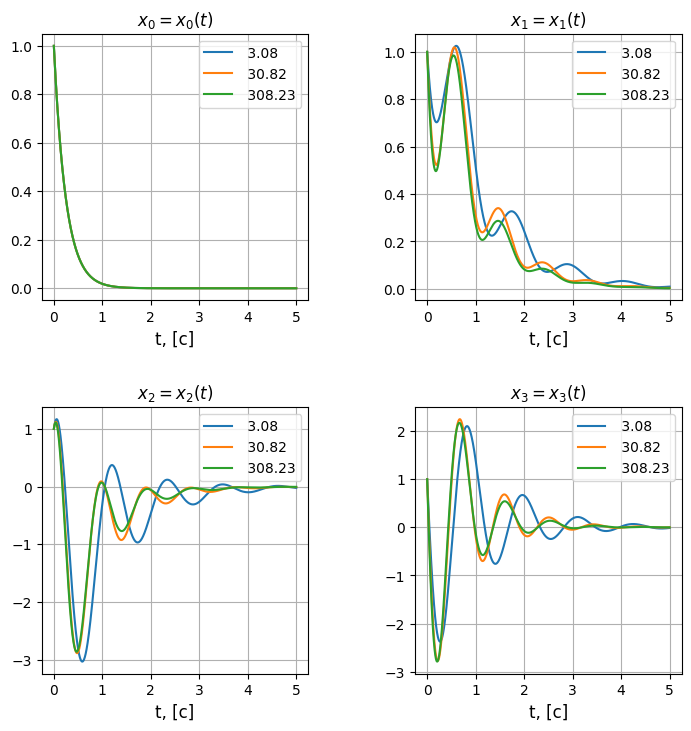

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, mu in enumerate(task2_reses1):
    res, _ = task2_reses1[mu]
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'{mu : .2f}') 
for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task2_1_states.jpg')

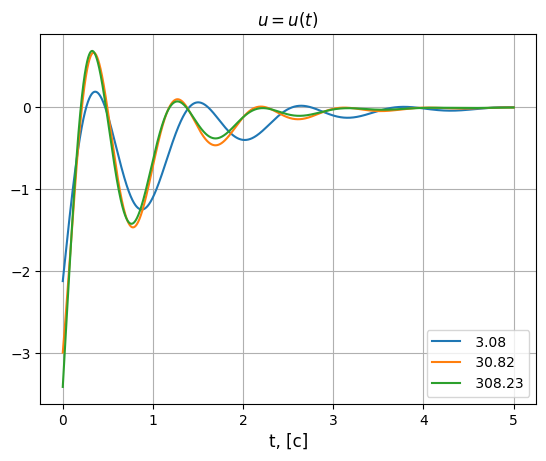

In [15]:
for indx, mu in enumerate(task2_reses1):
    res, K = task2_reses1[mu]
    us = K @ res.states
    plt.plot(ts, us[0], label=f'{mu : .2f}') 
plt.xlabel(f"t, [c]", fontsize=12)
plt.title(f"$u = u(t)$", fontsize=12)
plt.grid(True)
plt.legend()
plt.savefig(f'{SAVE_PATH}/task2_1_us.jpg')

In [16]:
task2_reses2 = dict()
ts = get_t(10)
for alpha in task1_reses:
    print(f'========   {alpha = }   =========')
    min_mu, K, val = task2_get_K_min(task1_A, task1_B, task1_x0.reshape(4, 1), alpha)
    print(f"{min_mu =}")
    if not val:
        print(':(')
        continue
    task2_reses2[(alpha, min_mu)] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

========   alpha = 0.1   =========
Optimization error: 1.564899052748183
min_mu =1.250959253032721
spec(A + B@K): [-0.1+5.15j -0.1-5.15j -0.1+0.j   -4. +0.j  ]; stable: True
\begin{bmatrix}
 -0.10 + 5.15j & -0.10 + -5.15j & -0.10 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
None
========   alpha = 1.0   =========
Optimization error: 9.500734593363262
min_mu =3.0823261659602577
spec(A + B@K): [-1.+5.5j -1.-5.5j -1.+0.j  -4.+0.j ]; stable: True
\begin{bmatrix}
 -1.00 + 5.50j & -1.00 + -5.50j & -1.00 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
None
========   alpha = 2.0   =========
Optimization error: 41.77012880029468
min_mu =6.462981417294551
spec(A + B@K): [-2.+6.13j -2.-6.13j -2.+0.j   -4.+0.j  ]; stable: True
\begin{bmatrix}
 -2.00 + 6.13j & -2.00 + -6.13j & -2.00 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
None
========   alpha = 3.0   =========
Optimization error: 138.9471040438235
min_mu =11.78758262086945
spec(A + B@K): [-3.+6.94j -3.-6.94j -3.+0.j   -4.+0.j  ]; stable: True
\begin{bmatrix}
 -3.00

0 (0.1, 1.250959253032721)
1 (1.0, 3.0823261659602577)
2 (2.0, 6.462981417294551)
3 (3.0, 11.78758262086945)


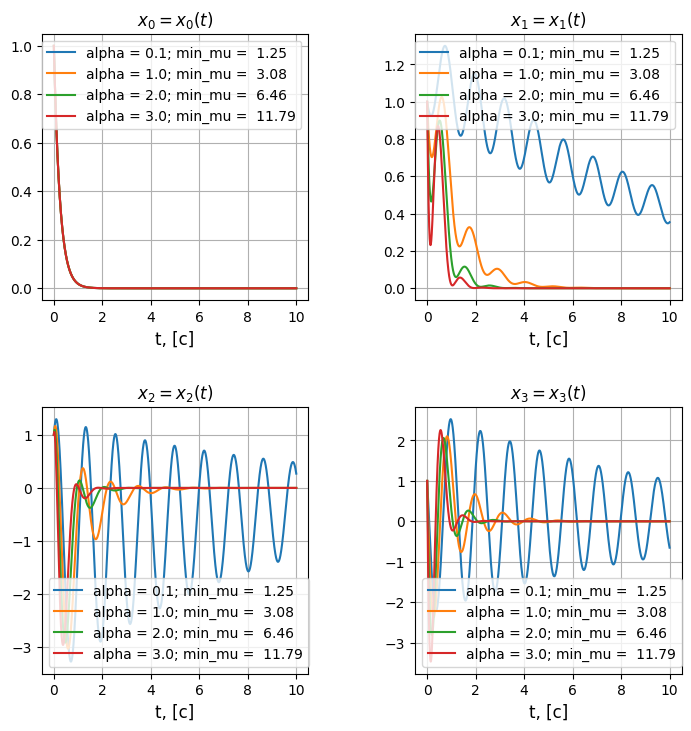

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, key in enumerate(task2_reses2):
    print(indx, key)
    res, _ = task2_reses2[list(task2_reses2.keys())[indx]]
    alpha, min_mu = key
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'{alpha = }; {min_mu = : .2f}') 
for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task2_2_states.jpg')

## Task 3

In [18]:
task3_A = np.array([
    [0, 4, 0, 0],
    [-4, 0, 0, 0],
    [0, 0, 0, 3],
    [0, 0, -3, 0]
])

task3_C = np.array([[5, 0, 0, 9]])

task3_specs = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])
task3_alphas = np.array([0.1, 1, 4])

task3_x0 = np.array([1, 1, 1, 1])
task3_xh0 = np.array([2, 0, 0, -1])

In [19]:
def task3_simulate(A, C, L, x0, xh0, ts):
    print(f'spec(A + LC): {np.linalg.eigvals(A + L @ C)}; stable: {np.all(np.linalg.eigvals(A + L @ C).real < 0)}')
    print(a2l.to_ltx(np.linalg.eigvals(A + L @ C)))
    ss_orig = control.ss(A, np.zeros((A.shape[0], 1)), C, np.zeros((C.shape[0], 1)))
    original_resp = control.forced_response(ss_orig, X0=x0, T=ts)
    ss = control.ss(A + L@C, L, A*0, L*0)
    return original_resp, control.forced_response(ss, X0=xh0, T=ts, U=-original_resp.outputs.reshape(-1))


def task3_get_L(A, C, alpha):
    Q = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((C.shape[1], C.shape[0]))
    
    lyapunov_lmi = A.T @ Q + Q @ A + 2 * alpha * Q + C.T @ Y.T + Y @ C
    constraints = [Q >> np.eye(4) , lyapunov_lmi << 0]
    objective = cvxpy.Minimize(0)
    
    prob = cvxpy.Problem(objective, constraints)
    try:
        # print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
        print(f'Optimization error: {prob.solve()}')
        
        print(f'spec(P): {np.linalg.eigvals(Q.value)}; Q >> 0: {np.all(np.linalg.eigvals(Q.value).real >= 0)}')
        print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
        # print(P.value)
    except Exception as e:
        print(e)
        return 0, False
    
    return np.linalg.pinv(Q.value) @ Y.value, True

In [29]:
task3_reses = dict()
ts = get_t(10)
for alpha in task3_alphas:
    print(f'========   {alpha = }   =========')
    L, status = task3_get_L(task3_A, task3_C, alpha)
    if not status:
        print(':(')
        continue
    print(f'L.T = {L.T}')
    task3_reses[alpha] = (task3_simulate(task3_A, task3_C, L, task3_x0, task3_xh0, ts), L)

========   alpha = 0.1   =========
Optimization error: 0.0
spec(P): [2.23 2.01 1.08 1.  ]; Q >> 0: True
spec(lmi): [-9.29e-08 -1.09e-02 -1.47e-01 -1.54e-01]; lyapunov_lmi <<= 0: True
L.T = [[-0.05 -0.03  0.01 -0.03]]
spec(A + LC): [-0.14+4.05j -0.14-4.05j -0.12+3.07j -0.12-3.07j]; stable: True
\begin{bmatrix}
 -0.14 + 4.05j & -0.14 + -4.05j & -0.12 + 3.07j & -0.12 + -3.07j
\end{bmatrix}
None
========   alpha = 1.0   =========
Optimization error: 0.0
spec(P): [82797.71 43786.61   329.19  1793.5 ]; Q >> 0: True
spec(lmi): [-3.54e+03 -2.08e+03 -2.67e-04 -8.09e+01]; lyapunov_lmi <<= 0: True
L.T = [[ 2.4  -3.04 -0.38 -2.35]]
spec(A + LC): [-2.64+6.01j -2.64-6.01j -1.92+2.93j -1.92-2.93j]; stable: True
\begin{bmatrix}
 -2.64 + 6.01j & -2.64 + -6.01j & -1.92 + 2.93j & -1.92 + -2.93j
\end{bmatrix}
None
========   alpha = 4.0   =========
Optimization error: 0.0
spec(P): [7.61e+08 9.54e+07 6.52e+04 8.69e+05]; Q >> 0: True
spec(lmi): [-6.44e+05 -9.87e+04 -4.57e+01 -8.29e+02]; lyapunov_lmi <<= 0: 

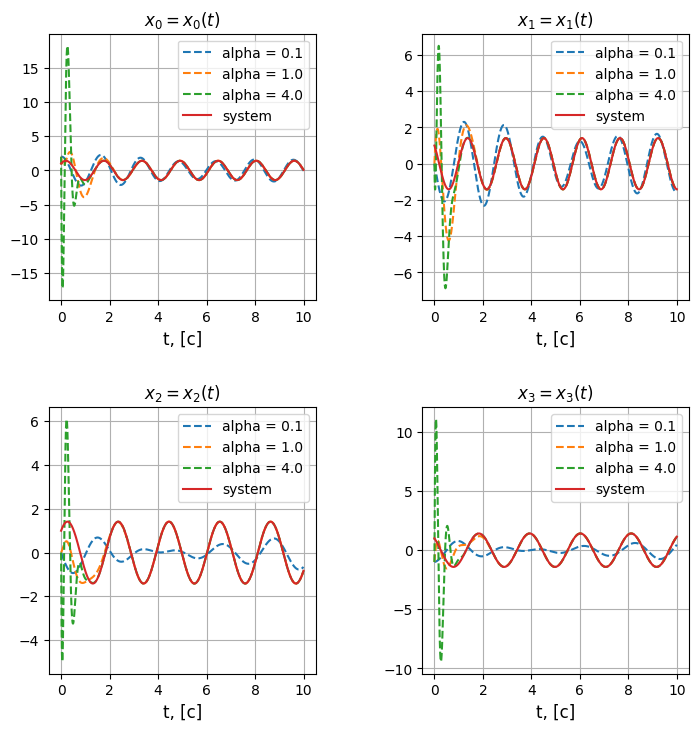

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, key in enumerate(task3_reses):
    (orig, obs), L = task3_reses[key]
    alpha = key
    for i, state in enumerate(obs.states):
        axs[i//2, i%2].plot(ts, state, '--', label=f'{alpha = }') 
    # break
for i, state in enumerate(orig.states):
        axs[i//2, i%2].plot(ts, state, label=f'system') 
for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task3_states.jpg')

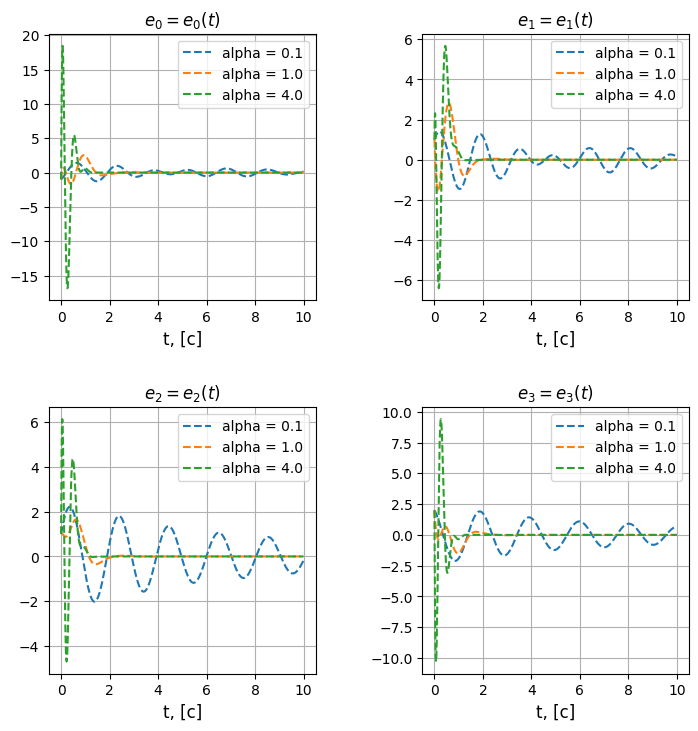

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, key in enumerate(task3_reses):
    (orig, obs), L = task3_reses[key]
    alpha = key
    for i, state in enumerate(obs.states):
        axs[i//2, i%2].plot(ts, orig.states[i] - obs.states[i], '--', label=f'{alpha = }') 
    # break
for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$e_{i} = e_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task3_errors.jpg')

In [23]:
task4_A = np.array([
    [5, -5, -9, 3],
    [-5, 5, -3, 9],
    [-9, -3, 5, 5],
    [3, 9, 5, 5]
])

task4_B = np.array([[2], 
                    [6], 
                    [6], 
                    [2]])

task4_C = np.array([
    [1, -1, 1, 1],
    [1, 3, -1, 3]
                    ])

task4_alphas = [0.1, 1, 4, 10]

check_observability_eigens(task4_C, task4_A)
check_controllability_eigens(task4_A, task4_B)

Eigen values of A:
   [-12.]: not observable
   [4.]: observable
   [16.]: observable
   [12.]: observable
Eigen values of A:
   [-12.]: controllable
   [4.]: controllable
   [16.]: controllable
   [12.]: controllable


In [58]:
def task4_get_e(alpha, ts):
    print(f'---------- {alpha} -------------')
    K, _ = task1_get_K(task4_A, task4_B, alpha)
    L, _ = task3_get_L(task4_A, task4_C, alpha)
    task4_new_A = np.block([[task4_A + task4_B @ K, -task4_B @ K], [np.zeros((task4_A.shape[0], K.shape[1] * 2 - task4_C.shape[1])), task4_A + L @ task4_C]])

    ss = control.ss(task4_new_A, task4_new_A * 0, task4_new_A * 0, task4_new_A * 0)
    res = control.forced_response(ss, T=ts, X0= 10 * np.ones((task3_A.shape[0]*2)))
    x = res.states[:4]
    e = res.states[4:]
    return e

    fig, axs = plt.subplots(2, 2, figsize=(8, 5))
    fig.suptitle(f'$\\alpha$ = {alpha}, max(e) = {np.max(e) : .1f}')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(x.shape[0]):
        # axs[i//2, i % 2].plot(ts, x[i], color='r', linewidth=4, label='system')
        # axs[i//2, i % 2].plot(ts, xh[i], '--', color='g', linewidth = 2, label='observer')
        axs[i//2, i % 2].plot(ts, e[i], linewidth = 2, label='error')
        axs[i//2, i % 2].set_title(f'$x_{i} = x_{i}(t)$', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
    plt.savefig(f'{SAVE_PATH}/task4_states_{alpha}.jpg')

---------- 0.1 -------------
Optimization error: 0.0
spec(P): [2.71e+04 2.26e+04 3.41e+00 1.72e+03]; P >> 0: True
spec(lmi): [  -141.74  -4706.03 -10594.69 -11171.42]; lyapunov_lmi <<= 0: True
Optimization error: 0.0
spec(P): [4.56e+09 1.33e+08 7.65e+06 9.77e+06]; Q >> 0: True
spec(lmi): [-1.21e+09 -8.08e+07 -5.88e+04 -2.77e+05]; lyapunov_lmi <<= 0: True
---------- 1 -------------
Optimization error: 0.0
spec(P): [2.36e+04 1.99e+04 1.04e+03 2.88e+00]; P >> 0: True
spec(lmi): [  -64.81 -3238.29 -8873.02 -9576.64]; lyapunov_lmi <<= 0: True
Optimization error: 0.0
spec(P): [63586564.2   2050758.     115971.65   118132.36]; Q >> 0: True
spec(lmi): [-19494613.84  -1165997.65   -340938.35   -155338.21]; lyapunov_lmi <<= 0: True
---------- 4 -------------
Optimization error: 0.0
spec(P): [6.47e+04 3.57e+04 8.09e+02 2.17e+00]; P >> 0: True
spec(lmi): [   -43.86  -4237.25 -18949.25 -21393.15]; lyapunov_lmi <<= 0: True
Optimization error: 0.0
spec(P): [42011843.95   552335.85    52968.4     5129

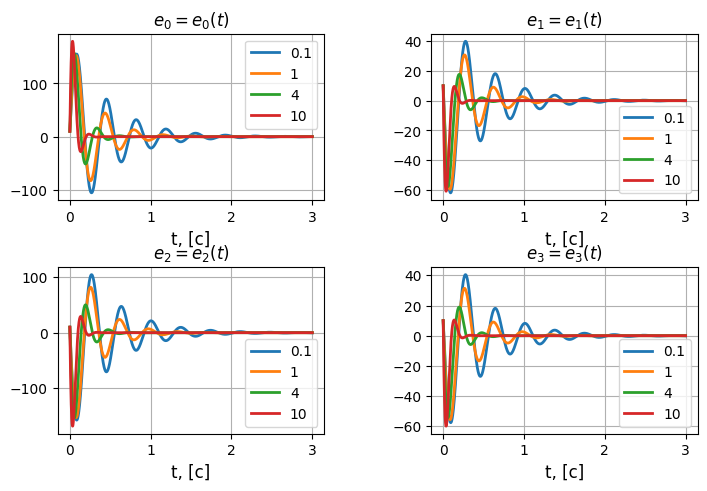

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

ts = get_t(3)
for task4_alpha in task4_alphas:
    es = task4_get_e(task4_alpha, ts)
    for i in range(es.shape[0]):
        # axs[i//2, i % 2].plot(ts, x[i], color='r', linewidth=4, label='system')
        # axs[i//2, i % 2].plot(ts, xh[i], '--', color='g', linewidth = 2, label='observer')
        axs[i//2, i % 2].plot(ts, es[i], linewidth = 2, label=f'{task4_alpha}')
        axs[i//2, i % 2].set_title(f'$e_{i} = e_{i}(t)$', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
plt.savefig(f'{SAVE_PATH}/task4_states.jpg')